\title{Natural Language Semantics with Pictures: Some Language \& Vision Datasets and Potential Uses for Computational Semantics}
\author{David Schlangen}

*David Schlangen, 2019-03-20*

**Natural Language Semantics with Pictures: Some Language & Vision Datasets and  Potential Uses  for Computational Semantics [ 12" Extended Mix ]**


Note: This is (mostly) an interactive / executable version of my IWCS 2019 paper of the same title. It looks best (and as intended) when the Jupyter extensions `latex_env`, `toc2`, and `codefolding` are installed; which can be done easily via [NB extensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/). 

This notebook here explains the general approach, the idea behind using language & vision corpora for investigating natural language semantic phenomena. This notebook should be read first. Next, there is a notebook describing the various image corpora and the basic annotations that the come with. Finally, the discussion of the various semantic tasks for which additional data is available, or could be constructed out of the available data, is spread over various further notebooks.


**Abstract**

Propelling, and propelled by, the "deep learning revolution", recent years have seen the introduction of ever more corpora of images annotated with natural language expressions that are meant to capture some aspects of their meaning. We survey some of these corpora, taking a perspective that reverses the usual directionality, as it were, by viewing the images as semantic annotation of the natural language expressions. We discuss datasets that can be derived from the existing annotation, and tasks of potential interest for computational semanticists that can be defined on those, such as learning *grounded interpretation functions*, detecting *semantic well-formedness*, and learning *implicature relations*.

# Introduction

In formal semantics -- or, more precisely, in *model-theoretic* formal semantics -- the central semantic notion "truth" is explicated as a relation between a sentence and a mathematical structure, its *model*. Semantics textbooks are surprisingly evasive about what exactly this structure is meant to be, other than hinting at that it in some way represents the general "situation", or "world", that the sentence is taken to be talking about. In any case, the model as a mathematical structure is intended to provide a collection of individuals about which the sentence could be talking, and an *interpretation* of the non-logical lexical items occurring in the sentence, in terms of sets of individuals (or of tuples of individuals). The collection of individuals is typically called the *domain* $D$, and the set of interpretations $I$, so that a model $M = \langle D, I\rangle$.

It is this intended relation with the world that allows us to see an analogy between these structures and photographic images. A photograph is a frozen moment in time, a representation of how the world was (or looked like) at a certain moment, at a certain place and from a certain perspective. And just as a sentence in formal semantics is evaluated relative to a model, a sentence describing a situation can be seen as true *relative to an image* -- if (and only if) the image *depicts* a situation of the described type. Hence, in a slight reversal of our usual way of talking, we can say that a given image does (or does not) make a given sentence true (instead of saying that the sentence is a true description of the image), and we can see the image as a model of the sentence. [footnote-1] [footnote-2]

What does this sleight of hand buy us? A very large amount of data to play with! The field of computer vision has as one of its central aims to find meaning in pixels (see e.g., \cite{davies:cv}, \cite{marr:vision}), and a convenient way of representing meaning is with natural language. It is also a field that has been data-driven for a long time, and so there is a large number of data sets available that in some way pair images with natural language expressions. [See for example the (incomplete) lists at <http://www.cvpapers.com/datasets.html> and <https://riemenschneider.hayko.at/vision/dataset/>.] Recent years have specifically seen the creating of large scale corpora where images are paired with ever longer and detailed language (e.g., single sentence or even full paragraph captions describing the image content; facts about the image spread over question and answer; detailed descriptions of parts of the image in terms of agents and patients; see references below). Given the understanding that all these expressions are meant to "fit" to the images that they are paired with, and using the slight conceptual inversion of treating the images as "truthmakers" for the sentences, this gives us an unprecendentedly large set of language expressions that are "semantically annotated".[footnote-3] 
These "annotations" are admittedly -- for linguists -- of an unusual type, as there are "analogue", as it were, but this arguably only makes it more interesting. (This is, after all, how the world comes to us in the most part: analogue, rather than packaged in symbolic representations.) 

The goal of the present paper is to provide a survey of some of the most interesting datasets from the perspective of natural language semantics, and to speculate about learning and evaluation tasks that could be set up with this data. Specifically, we will look at relations that can be read off the corpora (like the relation between an expression and an image; or between two expressions, relative to an image) or added via methods of natural language processing or computer vision (similarity relations between images or between expressions), and what we could learn from that about *semantic* relations like truth and entailment and about the (grounded) interpretation functions required to make them work.


**fn-1**[There are interesting subtleties here. In our everyday language, we are quite good at ignoring the image layer, and say things like "the woman is using a computer", instead of "the image shows a woman using a computer", or "this is a computer", instead of "this is an image of a computer". This also seems to carry over to tense, where we can say "is using", instead of "was using at the time when the picture was taken". There are however contexts in which talk about the image *as* image is relevant, and this can happen in large corpora such as discussed here. So this is something to keep in mind.]

**fn-2**[This perspective is implicitly taken in \cite{youngetal:flickr30k}, from where we took inspiration, but it is there not further developed in the way that we are attempting here.]

**fn-3**[(The Groningen Meaning Bank \cite{Bos2017GMB} and the Groningen Parallel Meaning Bank \cite{abzianidze-EtAl:2017:EACLshort}, as the largest currently available semantically annotated language resources, provide annotations for 25,000 sentences, whereas the number of expressions provided by the corpora discussed here goes in the millions. The Groningen annotations, however, are of a much finer grain; our claim here is that the discussed here can complement that data.)]

In [1]:
# imports

from __future__ import division
import codecs
import json
from itertools import chain, izip, permutations, combinations
from collections import Counter, defaultdict
import ConfigParser
import os
import random
from textwrap import fill
import scipy
import sys
from copy import deepcopy

from annoy import AnnoyIndex
from nltk.parse import CoreNLPParser
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [2]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = ConfigParser.SafeConfigParser()
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    config.readfp(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [3]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = ['mscoco_bbdf', 'refcoco_refdf', 'refcocoplus_refdf', 'grex_refdf',
            'vgpardf', 'cococapdf']
df = load_dfs(preproc_path, df_names)

# load up pre-computed similarities
coco_sem_sim, coco_sem_map = load_imsim(os.path.join(preproc_path, 'mscoco_sim.npz'))
visg_sem_sim, visg_sem_map = load_imsim(os.path.join(preproc_path, 'visgen_sim.npz'))
coco_id2semsim = invert_dict(coco_sem_map)
visg_id2semsim = invert_dict(visg_sem_map)

coco_vis_sim, coco_vis_map = load_imsim(os.path.join(preproc_path, 'mscoco_vis_sim.npz'))
visg_vis_sim, visg_vis_map = load_imsim(os.path.join(preproc_path, 'visgen_vis_sim.npz'))
coco_id2vissim = invert_dict(coco_vis_map)
visg_id2vissim = invert_dict(visg_vis_map)

# Images, Sentences, and Models

We have said above that our interest is in relations between natural language expressions and images, both those that we can read off the corpora and those that we can add using computational methods, and what these may mean for semantic relations such as *truth* and *entailment* ($\models, \vdash$). The following diagram illustrates this configuration.

![relations](Figures/relations.png)

We distinguish between relations that link expressions and images ($\mathcal{R}_{e/I}$), those that link pairs of images ($\mathcal{R}_{I/I}$), and those that link pairs of expressions ($\mathcal{R}_{e/e}$). 

We can read off the expression/image relation *annotates* from the corpora. (In the Figure, it holds between $e_1$ and $I_1$, $e_2$ and $I_1$, and $e_3$ and $I_2$.) Following the intended semantics of the annotation, and taking the perspective introduced above in the introduction, we can assume that for expressions that are sentential, it corresponds to the *models* or "*truth making*" relation (that is, $I_1 \models e_1$). We can ask whether from the individual instances of "truth making" in the corpora we can generalise and learn something more general about this relation. 

Indirectly, we can also read off the expression / expression relation "annotates same image" from the corpora. (In the Figure, it holds between $e_1$ and $e_2$, and it doesn't hold between $e_1$ (or $e_2$) and $e_3$.) Using computational methods, we can provide *similarity* relations both between expressions and between images (see below for details). As we will see below, we can ask whether these relations can help us to get at semantic *implicature* relations between expressions.

To formalise this, we have the following sets of relations, with our question being how we can relate the found relations (in the corpora) and the computed relations (similarities) to the semantic relations of interest:

- $\mathcal{R}_{e/I} = \{ \mathit{annotates}, [\![\cdot]\!]\}$ 
- $\mathcal{R}_{e/e} = \{ \mathit{annotates\_same\_I}, sim_{e/e}, \models, \vdash\}$ 
- $\mathcal{R}_{I/I} = \{ sim_{I/I}\}$ 

## Images as Models: An Example

Let us look at the proposed analogy between semantic models and images by going through an example. The following shows an image from one of the corpora, together with the information about the locations of objects overlayed on top of the image. The objects are identified with numerical identifiers. We can see this information as constituting one part of a semantic model, the *domain* $D$.

<IPython.core.display.Latex object>

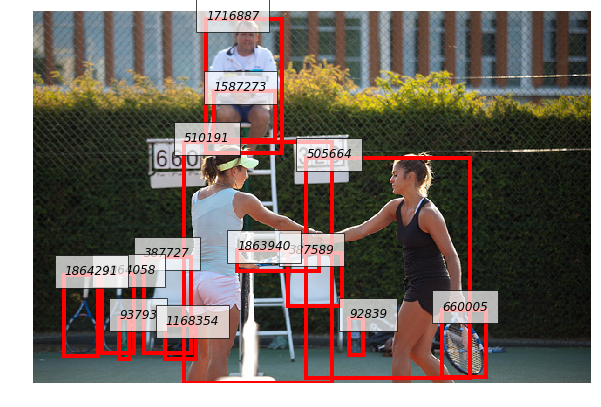

In [4]:
# load up one image from MSCOCO & overlay its bounding boxes and object IDs.
pick_row = 100
ic, ii  = df['refcoco_refdf'].iloc[pick_row][['i_corpus', 'image_id']]

this_anno = query_by_id(df['mscoco_bbdf'], (ic, ii), column=['bb', 'region_id']).values

display(Latex("$D = \\{" + ', '.join(['o_{' + str(rg) + '}' for _, rg in this_anno]) + "\\}$"))

plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, str(reg)) for b, reg in this_anno])

We can use this information to "reverse engineer" the interpretation function, as regards the words occurring in the expressions that are linked to the image in the corpus. In this particular example, there are two expressions containing the word "woman" that are respectively linked to different objects in this image. Under the assumption that they are meant to capture the "meaning" of image (i.e., be true descriptions), we can also assume that these objects capture the meaning of the word, in the sense that they are the value (for this domain) of its interpretation function:

<IPython.core.display.Latex object>

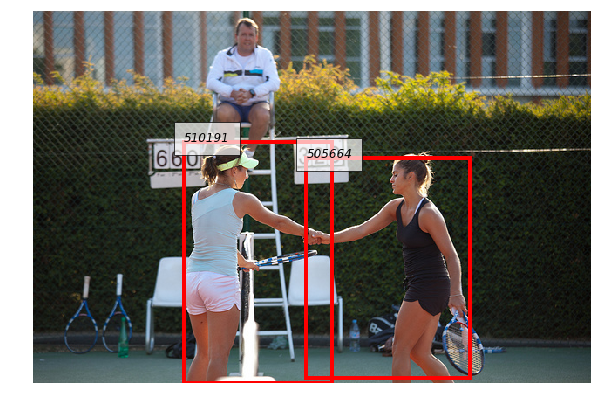

In [5]:
# get denotation of "woman" from referring expressions for this image
outcols = 'i_corpus image_id region_id refexp'.split()
combined = pd.concat([query_by_id(df['refcoco_refdf'], (ic, ii), column=outcols),
                      query_by_id(df['refcocoplus_refdf'], (ic, ii), column=outcols),
                      query_by_id(df['grex_refdf'], (ic, ii), column=outcols)])
i_woman = [r for c,i,r in create_word2den(combined)['woman']]
display(Latex('$I(woman) = \\{' + ', '.join(['o_{' + str(i) + '}' for i in i_woman]) + '\\}$'))
plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, str(reg)) for b, reg in this_anno if reg in i_woman])

We should note here that the way we have put it above requires making an additional *exhaustivity* assumption: If the word were applicable to other objects in the image, it would have been annotated as such. This is not something that is guaranteed by any of the corpora we will look at here. (And in fact, this marks one difference between free-form language annotation of images and *labelling* them with labels from a pre-defined set.) Hence making this assumption may add some noise to the data when sampling *negative* examples for an interpretation function.

There is also the question of *coverage* of the object segmentation. As the example above has shown, not all objects in the image are marked (e.g., the fence, the hedge, and the building in the background). As long as we only work with the set of pre-segmented objects, this is less of a problem; it may become one if one makes the step towards working with unsegmented images.

We can think a little bit more about the perspectives this opens for doing semantics. In our domain $D$, we suddenly have not just identifiers or symbols from a vocabulary, but rather objects that have an internal structure:

<IPython.core.display.Latex object>

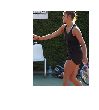

In [6]:
# show image patch corresponding to object
for this_obj in i_woman[:1]:
    this_bb = [int(e) for e in [e[0] for e in this_anno if e[1] == this_obj][0]]
    display(Latex('$o_{' + str(this_obj) + '} =$'))
    plot_img_cropped(get_image_filename(config, ic, ii), this_bb, width=1, height=2)

What can we do with this? For this particular model (image), we have taken $[\![\mathrm{woman}]\!]$ (the interpretation of "woman", in this particular domain) from the natural language annotation. We can now try to use this information to generalise the function to all images in general. That is, we can try to turn $I$ into a "constructive" function that not just records a fact ("object o is in the denotation of predicate p"), but rather produces a *judgement*.

To make this more explicit, we can change the notation slightly, and make the domain an explicit argument of the function: $I_{woman}(D)$. Seen this way, the interpretation function turns into a *filter* on the domain, letting through only those objects that are judged to be in the denotation of the respective predicate. We can thus locate the function of connecting language and world here, in the interpretation function of each word.

(We would probably want to set this up in such a way that we can represent uncertainty about such judgements, turning denotations into fuzzy sets where each object is associated with a judgement about or confidence in membership. We have begun to explore this strategy in \cite{schlaetal:imagewac}. It would be an interesting project to fully think through whether this approach imports all the problems that were discussed in the 1980s and 1990s in relation to grounding semantics on fuzzy logic [e.g., \cite{KampPartee:prototypes}], but this is not an issue that can be explored here.)

## Images as Implicit Link between Expressions

Besides the question of whether a statement is true of a given situation, an interesting question often is whether a statement *follows* from another one. There are various ways of tying down what exactly "follows" may mean. A very general, cognitive one is given by \cite{chierchi:meaning}, who use "A implies B" for cases where (the statement and acceptance of) A *provides reason* to also accept B. This covers cases where a *proof* can be given that connects B to A (where the relation would be *syntactic consequence*, $\vdash$), cases where an argument can be made that any model that makes A true will also make B true (*semantic consequence*, $\models$), but also cases where A may just make B very plausible, given common sense knowledge (which we might call *common sense implicature*, and denote $\models_{cs}$).

We will see many more examples below, but just to give a taste of how we will proceed there, the following shows some pairs of expressions either taken from the same image object, or taken from a different one. This should make it plausible that there does indeed seem to be a *semantic* relation that holds (more?) between expressions connected to the same image object than between random pairs.

(For reasons that will become clear later, we call the A part of the relation "premise", and the candidates for the B part either "positive hypothesis" (if it comes from the same image object) or "negative hypothesis" (if it doesn't).)

In [7]:
# pairing premise and hypotheses
n = 4 # how many to do
triples = []

this_df = df['refcoco_refdf']

for _ in range(n):
    # seed image
    ic, ii, ri, rexi = this_df.sample()['i_corpus image_id region_id rex_id'.split()].values[0]
    premise, phyp =  np.random.choice(query_by_id(this_df, (ic, ii, ri), 'refexp'), 2, replace=False)

    # negative hypothesis
    nhyp = this_df.sample()['refexp'].values[0]
    triples.append((premise, phyp, nhyp))

colnames = 'premise p-hyp n-hyp'.split()
#pd.DataFrame(triples, columns=colnames)

for prem, phyp, nhyp in triples:
    print "-" * 40
    print "premise: ", prem
    print "p-hyp:   ", phyp
    print "n-hyp:   ", nhyp
    
print ""
    
# pairing premise and hypotheses
n = 4 # how many to do
triples = []

this_df = df['cococapdf']

for _ in range(n):
    # seed image
    ic, ii, rexi = this_df.sample()['i_corpus image_id id'.split()].values[0]
    premise, phyp =  np.random.choice(query_by_id(this_df, (ic, ii), 'caption'), 2, replace=False)

    # negative hypothesis
    nhyp = this_df.sample()['caption'].values[0]
    triples.append((premise, phyp, nhyp))

#colnames = 'premise p-hyp n-hyp'.split()
#pd.DataFrame(triples, columns=colnames)

for prem, phyp, nhyp in triples:
    print "-" * 40
    print "premise: ", prem
    print "p-hyp:   ", phyp
    print "n-hyp:   ", nhyp

----------------------------------------
premise:  front red bag
p-hyp:    red bag in front
n-hyp:    middle glass bottom
----------------------------------------
premise:  guy on left with back turned to uswho does he think he is
p-hyp:    left cop
n-hyp:    left kid
----------------------------------------
premise:  left blue runner
p-hyp:    left girl blue
n-hyp:    woman right red
----------------------------------------
premise:  right sofa
p-hyp:    couch right
n-hyp:    woman on top

----------------------------------------
premise:  A restroom is featured with multiple sinks and hand soap.
p-hyp:    a bathroom with three sinks and thre mirrors
n-hyp:    A cluttered living room is shown with the TV on.
----------------------------------------
premise:  a star bucks drink a book  and pastry on a table
p-hyp:    A table with a coffee drink, a pastry and a book.
n-hyp:    A man brushing his teeth with a blue toothbrush.
----------------------------------------
premise:  A man in bl

Here are pairs of sentences where either both describe the same, or each a different image.

In [8]:
# pairing premise and hypotheses
n = 5 # how many to do
triples = []

this_df = df['cococapdf']

for _ in range(n):
    # seed image
    ic, ii, rexi = this_df.sample()['i_corpus image_id id'.split()].values[0]
    premise, phyp =  np.random.choice(query_by_id(this_df, (ic, ii), 'caption'), 2, replace=False)

    # negative hypothesis
    nhyp = this_df.sample()['caption'].values[0]
    triples.append((premise, phyp, nhyp))

#colnames = 'premise p-hyp n-hyp'.split()
#pd.DataFrame(triples, columns=colnames)

for prem, phyp, nhyp in triples:
    print "-" * 40
    print "premise: ", fill(prem, 70)
    print "p-hyp:   ", fill(phyp, 70)
    print "n-hyp:   ", fill(nhyp, 70)

----------------------------------------
premise:  A watch and clock repair shop window with clocks on display.
p-hyp:    A room filled with clocks through a window.
n-hyp:    Man swinging baseball bat while catcher holds open glove out
----------------------------------------
premise:  Group of bears walking across a road from a forrest.
p-hyp:    Four bears are crossing a road next to some woods.
n-hyp:    A bathroom with a shower, toilet, and sink.
----------------------------------------
premise:  The person in a blue shawl is holding a colorful kite's string.
p-hyp:    A woman begins to fly a kite in the park.
n-hyp:    A small bedroom picture taken through a fisheye lens
----------------------------------------
premise:  A furry cat drinking water from a sink
p-hyp:    A cat that is drinking water from a sink.
n-hyp:    A man riding a skateboard in an empty parking lot.
----------------------------------------
premise:  Two horses are by the water and there are a bunch of horses 

As this will also have shown already, the datasets that we can derive in such an automated fashion will be noisy: We may happen to hit on a pair where the relation intuitively should not hold (without further context), or where it accidentally may hold, even if the expression is taken from a randomly sampled different image. We will discuss below ways to control for that to a certain degree, but a certain amount of noise in the data seems unavoidable.

# Computed Links

As we have said above, some relations between objects of the same type (i.e., either pairs of images, $\mathcal{R}_{I/I}$, or pairs of expressions, $\mathcal{R}_{e/e}$) can be computed automatically. We will make use of this when we discuss specific semantic tasks. But to give a preview, here is a randomly selected picture (left) and two images deemed similar using different ways of computing "similarity"; namely, going by the annotation and ground truth knowledge of what is in the image (middle), and comparing automatically derived representations of the images (right).

A baby gray elephant has big ears. The small tusk is white. The trunk has
wrinkles on it and it is curled on the tip. The field has short brown grass.


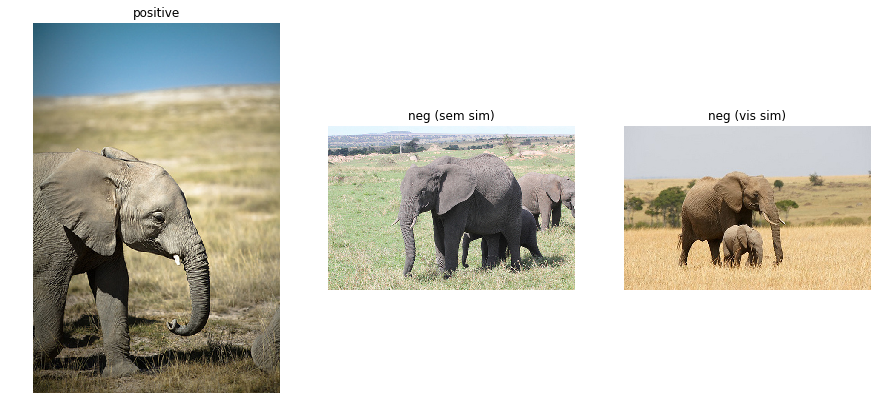

In [9]:
# Example of paragraph & negative examples, selected by semantic and visual similarity
nii = False
while not nii:
    ic, ii, par = df['vgpardf'].sample()['i_corpus image_id paragraph'.split()].values[0]
    if ii in visg_id2semsim and ii in visg_id2vissim:
        nii = n_most_sim(visg_sem_sim, visg_sem_map, visg_id2semsim[ii])[1]
        niis = n_most_sim(visg_vis_sim, visg_vis_map, visg_id2vissim[ii])[1]

    

print fill(par, 80)
_, ax = plt.subplots(1,3, figsize=(15, 15))
plot_img_ax(config, ax[0], 'visual_genome', ii, title="positive")
plot_img_ax(config, ax[1], 'visual_genome', nii, title="neg (sem sim)")
plot_img_ax(config, ax[2], 'visual_genome', niis, title="neg (vis sim)")

The following shows an expression (an image caption) from one of our corpora, and its five nearest neighbours in a sentence embeddings space \cite{Cer2018}.

In [10]:
# load up the nearest neighbour index of captions in embedding space. Slow-ish.
ind = AnnoyIndex(512, metric='euclidean')
ind.load(os.path.join(preproc_path, 'caps.ann'))

# the embedding index works via the row number in cococapdf, so need mapping

# N.B.: this is actually lossy. This is the row of the *first* caption for that
#  image. But there will also be other rows (captions) for same image.
#  So, should really one to many mapping. But for purposes here, is ok.
coco2row = dict(zip(df['cococapdf']['image_id'].tolist(), df['cococapdf'].index.tolist()))

In [11]:
# Show a caption and its 5 nearest neighbours, in a sentence embedding space.
pick_row = 100
ic, ii  = df['cococapdf'].iloc[pick_row][['i_corpus', 'image_id']]

this_row = coco2row[ii]
nns = ind.get_nns_by_item(this_row, 5)

print df['cococapdf'].iloc[pick_row]['caption']
for nn in nns:
    print df['cococapdf'].iloc[nn]['caption']

A group of skiers stand atop a snowy peak.
Skiers are standing at the top of a snow-covered mountain.
Three skiers standing near the top of a mountain slope.
People on skis are standing on the top of a mountain.
Four skiers stand atop of a snow covered mountain. 
A group of skiers standing at the base of a mountain


# References

[<a id="cit-davies:cv" href="#call-davies:cv">1</a>] E. R. Davies, ``_Computer and Machine Vision: Theory, Algorithms, Practicalities_'',  2012.

[<a id="cit-marr:vision" href="#call-marr:vision">2</a>] David Marr, ``_Vision: A Computational Investigation into the Human Representation and Processing of Visual Information_'',  1982.

[<a id="cit-youngetal:flickr30k" href="#call-youngetal:flickr30k">3</a>] Young Peter, Lai Alice, Hodosh Micah <em>et al.</em>, ``_From image descriptions to visual denotations: New similarity metrics for semantic inference over event descriptions_'', Transactions of the Association for Computational Linguistics, vol. 2, number , pp. ,  2014.

[<a id="cit-Bos2017GMB" href="#call-Bos2017GMB">4</a>] Johan Bos, Valerio Basile, Kilian Evang <em>et al.</em>, ``_The Groningen Meaning Bank_'',  2017.

[<a id="cit-abzianidze-EtAl:2017:EACLshort" href="#call-abzianidze-EtAl:2017:EACLshort">5</a>] L. Abzianidze, J. Bjerva, K. Evang <em>et al.</em>, ``_The Parallel Meaning Bank: Towards a Multilingual Corpus of Translations Annotated with Compositional Meaning Representations_'', Proceedings of the 15th Conference of the European Chapter of the Association for Computational Linguistics: Volume 2, Short Papers, April 2017.  [online](http://www.aclweb.org/anthology/E17-2039)

[<a id="cit-schlaetal:imagewac" href="#call-schlaetal:imagewac">6</a>] D. Schlangen, S. Zarrie{\ss} and C. Kennington, ``_Resolving References to Objects in Photographs using the Words-As-Classifiers Model_'', Proceedings of ACL 2016, August 2016.

[<a id="cit-KampPartee:prototypes" href="#call-KampPartee:prototypes">7</a>] Kamp H and Partee B, ``_Prototype theory and compositionality._'', Cognition, vol. 57, number 2, pp. 129--191,  1995.

[<a id="cit-chierchi:meaning" href="#call-chierchi:meaning">8</a>] Gennaro Chierchia and Sally McConnell-Ginet, ``_Meaning and Grammar: An Introduction to Semantics_'',  1990.

[<a id="cit-Cer2018" href="#call-Cer2018">9</a>] Cer Daniel, Yang Yinfei, Kong Sheng-yi <em>et al.</em>, ``_Universal Sentence Encoder_'', ArXiv, vol. , number , pp. ,  2018.  [online](http://arxiv.org/abs/1803.11175)

